# Usage of the Event Detector by Liu et al.

# Load the required packages

In [4]:



# Import public packages
import sys
import os
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import glob
from datetime import datetime, timedelta
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from io import StringIO

# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_Liu_Ripple
import BLUED_loader as blued

# Activate Autoreload
%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [2]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
CURRENT_COLUMN = "Current B"
NETWORK_FREQUENCY_BLUED = 60
SAMPLES_PER_SECOND_BLUED = NETWORK_FREQUENCY_BLUED #because we compute period wise datapoints
SAMPLERATE_BLUED = 12000

# For the event detector
init_dict_BLUED = {"median_filter_window" : 9,
"q_ripple_window_size" : 10, 
"power_threshold" : 10, 
"perform_input_order_checks": True,
"window_size_n" : 5 * 21 #5 times the q_ripple_window_size is an assumption
                 } 


SAMPLES_FEATURE_PER_WINDOW_BLUED = init_dict_BLUED["window_size_n"]
WINDOW_SIZE_SECONDS_BLUED = SAMPLES_FEATURE_PER_WINDOW_BLUED / SAMPLES_PER_SECOND_BLUED

# Compute how big the window is regarding the raw samples --> this is used for the streamiong
samples_raw_per_window_BLUED = SAMPLERATE_BLUED *  WINDOW_SIZE_SECONDS_BLUED
seconds_per_feature_sample = 1 / SAMPLES_PER_SECOND_BLUED
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 


# Load and display the BLUED Test File

<IPython.core.display.Javascript object>


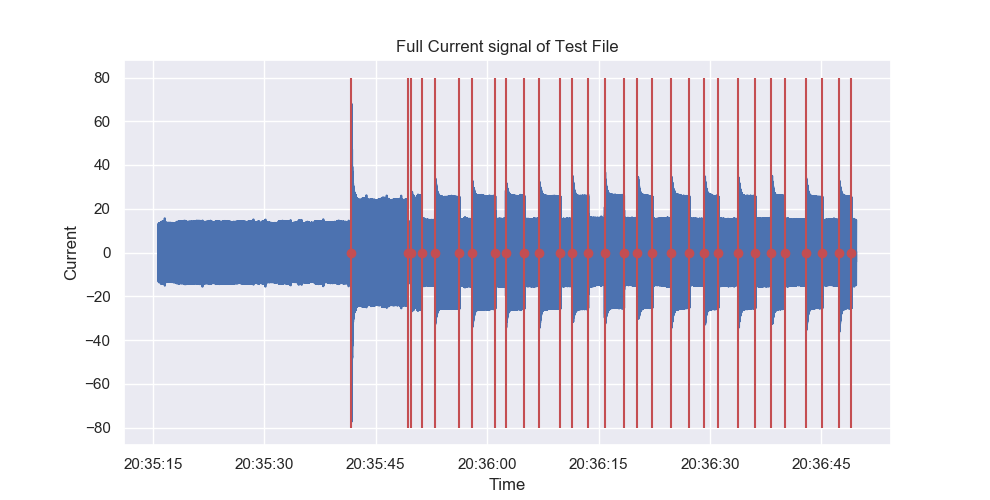

In [5]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data, file_info = blued.load_file(test_file)

lable_path:str = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.csv"))[0]
data_start = file_info['file_start']
data_end = file_info['file_end']

labels = blued.load_labels(lable_path, data_start, data_end)

current = data["Current"]
voltage = data["Voltage"]

# Plot the data from the test File
_, ax = plt.subplots(figsize=(9.9,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=labels.index, color='r',ymin=-80, ymax=80, zorder=101)
plt.show()


# Run the Event Detection on the Test Data

In [6]:
found_events=[]
show_plots = False

samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window

# Step 1: Initialize  the Event Detector with the Hypperparameter dictionary 
Liu = EventDet_Liu_Ripple(**init_dict_BLUED) #i.e. values are unpacked into the parameters
Liu.fit() # Call the fit() method to further initialize the algorithm (required by the sklearn API)

# As we will stream overlapping windows with a relative offset to each other we set this here
relative_offset = Liu.q_ripple_window_size * 2 # is 2q and -1 because we need it to be negative
relative_offset = (relative_offset / 60) * SAMPLERATE_BLUED # convert the relative offset that is relative to the feature domain
# to the relative offset for the raw input domain. 
# we devide by 60 as we have 60 feature points per second to get the number of seconds and then we multpily by the sampling rate
# to get the number of raw samples required.

while samples_remaining >= samples_raw_per_window_BLUED: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + samples_raw_per_window_BLUED) # compute end index of the new window

    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]
    
    window_start_timestamp = current_window.index[0]
    window_end_timestamp = current_window.index[-1]
    
    print(">"+ f" ({window_start}-{window_stop})")

    # Step 2: Use the feature computation function of the algorithm to compute the input features
    X = Liu.compute_input_signal(voltage=voltage_window, current=current_window, period_length=BLUED_period) 
    
    # Plot the computed features
    if show_plots:
        plt.title("Computed input features for this window")
        plt.plot(X)
    
    # Step 3: Run the prediciton on the features
    events = Liu.predict(X) 

    if len(events) > 0: # if an event is returned
        print(f"({voltage_window.index[0]}  -  {voltage_window.index[-1]})")
        event_timestamps = []
        # Convert indices to timestamps for the postprocessing
        for event_index in events:
            event_timestamps.append(window_start_timestamp + timedelta(seconds=event_index * seconds_per_feature_sample))
            
        # As the algorithm is very sensitive, we have applied postprocessing like the other reference algorithms
        # to filter out events that are detected within a certain time limit, i.e. here 1 second.
        # so events that fall within this timeframe are treated as one event.
        events_postprocessed = Liu.event_list_postprocessing(event_timestamps, postprocessing_limit=1)
        
        if len(events_postprocessed)>0:
            for event in events_postprocessed:
                print("Event Detected at " + str(event))
                found_events.append(str(event))
                
                if show_plots:
                    time_delta = window_end_timestamp-window_start_timestamp
                    time_delta_ms= int(time_delta.total_seconds()*10000)

                    pos_event = int((event - window_start_timestamp).total_seconds()*10000)
                    relative_pos = pos_event/time_delta_ms

                    event_idx = int(len(X)*relative_pos)
                    plt.vlines(x=[event_idx], color='red',ymin=np.min(X), ymax=np.max(X), zorder=101)
        
    if show_plots:
        plt.show()
        
    # We start at the end of the previous window
    window_start = int(window_stop - relative_offset)
    #print("+++++++++++++++++++++++++++++++++++")
    
    # We need to update the data points that remain for streaming now.
    samples_remaining -= samples_raw_per_window_BLUED
    

> (0-21000)
> (17000-38000)
> (34000-55000)
> (51000-72000)
> (68000-89000)
> (85000-106000)
> (102000-123000)
> (119000-140000)
> (136000-157000)
> (153000-174000)
> (170000-191000)
> (187000-208000)
> (204000-225000)
> (221000-242000)
> (238000-259000)
> (255000-276000)
> (272000-293000)
> (289000-310000)
> (306000-327000)
(2011-10-23 20:35:41.273499  -  2011-10-23 20:35:43.023416)
Event Detected at 2011-10-23 20:35:41.723499
> (323000-344000)
> (340000-361000)
(2011-10-23 20:35:44.106832  -  2011-10-23 20:35:45.856749)
Event Detected at 2011-10-23 20:35:44.323499
> (357000-378000)
> (374000-395000)
> (391000-412000)
(2011-10-23 20:35:48.356832  -  2011-10-23 20:35:50.106749)
Event Detected at 2011-10-23 20:35:49.290165
> (408000-429000)
(2011-10-23 20:35:49.773499  -  2011-10-23 20:35:51.523416)
Event Detected at 2011-10-23 20:35:49.956832
Event Detected at 2011-10-23 20:35:51.173499
> (425000-446000)
> (442000-463000)
(2011-10-23 20:35:52.606832  -  2011-10-23 20:35:54.356749)
Even

<IPython.core.display.Javascript object>


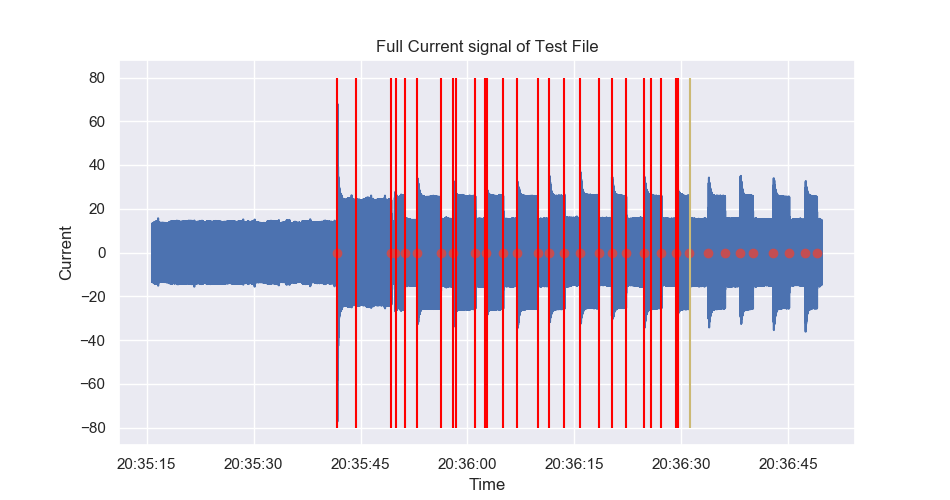

In [9]:
_, ax = plt.subplots(figsize=(9.5,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=found_events, color='red',ymin=-80, ymax=80, zorder=101)

#end of sliding window
ax.vlines(x=data.index[window_stop], color='y',ymin=-80, ymax=80, zorder=101)
plt.show()